---
# Diagnosis of mechanical rotor faults in drones using functional gaussian mixture classifier
B. Bartoszewski,
K. Jarzyna
---

---

### Problem formulation [0-4 pts]:
  - is the problem clearly stated [1 pt]
  - what is the point of creating model, are potential use cases defined [1 pt]
  - where do data comes from, what does it containt [1 pt]
  - DAG has been drawn [1 pt]
  - confoundings (pipe, fork, collider) were described [1 pt]

#### *Detection of Drone Propeller Damage*

<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
A program has been developed for detecting damage to drone propellers, based on data from the accelerometer and gyroscope. The system analyzes changes in the drone's vibrations and movements, allowing for early detection of anomalies indicating mechanical damage to the propellers. This enables quick corrective actions, minimizing the risk of further damage, and improving the safety and reliability of drone operations.
</div>



#### *Potential use*
<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
By analyzing vibration patterns, the system can quickly identify anomalies that may suggest damage or wear of components. When unusual vibrations are detected, the system immediately alerts the operator, enabling prompt actions such as controlled landing for inspection and potential replacement of damaged parts.

Using this program can reduce the risk of multirotor flights and decrease the operational cost of drones by mitigating the potential destruction of the entire drone or surrounding infrastructure.
</div>



#### *Collecting Data*
<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
The data was collected by our own. To gather data, flights were conducted using an eight-rotor drone. Initially, flights were carried out with all propellers in good condition, followed by series of flights with one damaged propeller measuring 1.5 cm in length. Subsequently, the damaged propeller was replaced with one measuring 3 cm in length, and the series of tests continued.
</div>

<style>
.justify {
    text-align: justify;
}
.center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
</style>

<div class="justify">
</div>
<p style="text-align: center;">A healthy drone used for collecting data.</p>
<img src="photos/IMG_3984.JPEG" alt="Photo of drone to collect data" class="center"/>

<p style="text-align: center;">One propeller cut 1.5 cm</p>
<img src="photos/1_5cm.jpg" alt="Photo of drone to collect data" class="center"/>

<p style="text-align: center;">One propeller cut 3 cm</p>
<img src="photos/3cm.jpg" alt="Photo of drone to collect data" class="center"/>





<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">

The system used in the drone is [Ardupilot](https://ardupilot.org/). It is an open-source autopilot designed for controlling, among other things, unmanned aerial vehicles.

One of the important features of ArduPilot is the ability to record flight data onto an external SD card. The capability of collecting flight logs was utilized, where the appropriate [logging parameters](https://ardupilot.org/copter/docs/parameters.html#log-bitmask) needed to be selected before the flight to gather data from the flights.

</div>

<p style="text-align: center;">Set <a href="https://ardupilot.org/copter/docs/parameters.html#log-bitmask" target="_blank">logging parameters</a></p>
<img src="https://ardupilot.org/copter/_images/mp_dataflash_log_bitmask.png" alt="Opis obrazu" width="1000"  class="center"/>

---
### Data preprocessing   [0-2 pts]:
- is preprocessing step clearly described [1 pt]
- reasoning and types of actions taken on the dataset have been described [1 pt]



#### *Data preprocessing*

<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">

After collecting data, files from the `logs_from_flights` folder were replayed in the [UAV Log Viewer](https://plot.ardupilot.org/) program to export data from the gyroscope and accelerometer. This program was used because it allowed for a clear visualization of the drone's flight trajectory and ensured that the exported data corresponded to the appropriate flights with the relevant damages.
</div>



<style>
.justify {
    text-align: justify;
}
.center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
</style>

<div class="justify">
</div>
<p style="text-align: center;">Data visualization in <a href="https://plot.ardupilot.org/" target="_blank">UAV Log Viewer</a></p>
<img src="photos/uav_logs.png" alt="Opis obrazu" width="27530"  class="center"/>


<style>
.justify {
    text-align: justify;
}
</style>

<div class="justify">
In file preprocessing.ipynb was made preprocessing from data whitch was generated in UAV Log Viewer. We saved thee types of data:

- accelerometer data in the time domain
- gyroscope data in the frequency domain
- gyroscope data in the frequency domain with accumulation

</div>

At the beginning, Euclidean normalization of the data was performed to reduce the dimensions to one.

$$
\|\mathbf{acc}\|_2 = \sqrt{acc_x^2 + acc_y^2 + acc_z^2}
$$

<p style="text-align: center;">Data saved and normalized from the accelerator </p>
<img src="photos/data_from_acc.pmg.png" alt="Opis obrazu" width="900"  class="center"/>

The same operation was performed for the gyroscope.

<p style="text-align: center;">Data saved and normalized from the accelerator </p>
<img src="photos/gyro.png" alt="Opis obrazu" width="900"  class="center"/>

The data was subjected to the removal of unit jumps that occur during takeoff and landing, which could reduce the model's effectiveness. Additionally, gyroscope data was subjected to Fourier transformation to examine how vibrations behave at different frequencies. 

<p style="text-align: center;">Gyroscope data after the Fourier transform.</p>
<img src="photos/gyro_fft.png" alt="Opis obrazu" width="900"  class="center"/>


Before exporting the data to the model, the flight data was divided into segments every 1.5 seconds. This aims to match the input data to the models, where the first and second models have a sliding window, and the third model aggregates the data.
</div>



---
### Model [0-4 pts]:
- are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt] 
- are difference between two models explained [1 pt]  
- is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]  
- are two different models specified [1 pt]

We decided to use Bayesian Mixture Model as our binary classifier. We assume that a given measurement, $y$, represented using B-spline basis can be drawn from one of $M$ data generating processes (which represents our fault classes), each described by unique set of parameters. To create this model, we need to build the likelihood function and then use it to develop the posterior distribution. 

Data generating process is given by

$$ y \sim Normal(\mu, \sigma) $$
$$ \mu = \sum_{m=1}^M \beta_m \phi_m(t) $$

where $y$ is sampled signal with uncertanity of normal distribution given by $\sigma$. Functions $\phi_m(t)$ are B-splines on assigned M knot grid. $\mu$ represents transformed parameters of the model, as it corresponds to the mean of fitted distribution of each class. $\beta_m$ are terms regulating each spline values, all are descirbed by normal distribution

$$ \beta_m \sim Normal(\mu_b,\sigma_b) $$

Our two model differs in number of used splines to represent signals, the more we use the better we can approximate signal however we are also greatly increasing computational time and risk overfitting. First model uses 15 splines and second 57. We decided on this numbers because initial experiments yielded promising results with low number of basis functions, however increasing them one by one was slowly improving correct classifications.


---
### Priors [0-4 pts]: Kacper
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- Is it explained why particular priors for parameters were selected [1 pt]


We have chosen following priors for both of our models:
$$ \sigma \sim Exponential(1) $$
$$ \beta \sim Normal(0,1) $$

For $\beta$, we selected a weakly informative prior - uniform distribution since we didn't have a strong rationale for choosing a different one due to nature of representing signal as a set of basis functions. For $\sigma$, we opted for an exponential prior because its thicker tail provides greater flexibility.

With priors chosen we proceed to prior predictive analysis

In [4]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from cmdstanpy import CmdStanModel
import cmdstanpy
import arviz as az
import pandas as pd
import csv,re

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200
acc_healthy = pd.read_csv('data_preprocesed/acc_healthy_samples.csv')
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])


prior_model_1 = CmdStanModel(stan_file='stan/prior_check.stan')

num_knots = 15
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)

data_ppc = {
    "N": N,
    "K": num_knots+2,
    "X": B0
}
ppc_samples = prior_model_1.sample(data=data_ppc)


20:17:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:18 - cmdstanpy - INFO - CmdStan done processing.


We present samples generated by our model by using ribbon plot on which we can see 90th percentile of generated samples and for comparison we are showing in black real signal from healthy drone. As we can see our model is capable of generating signals.

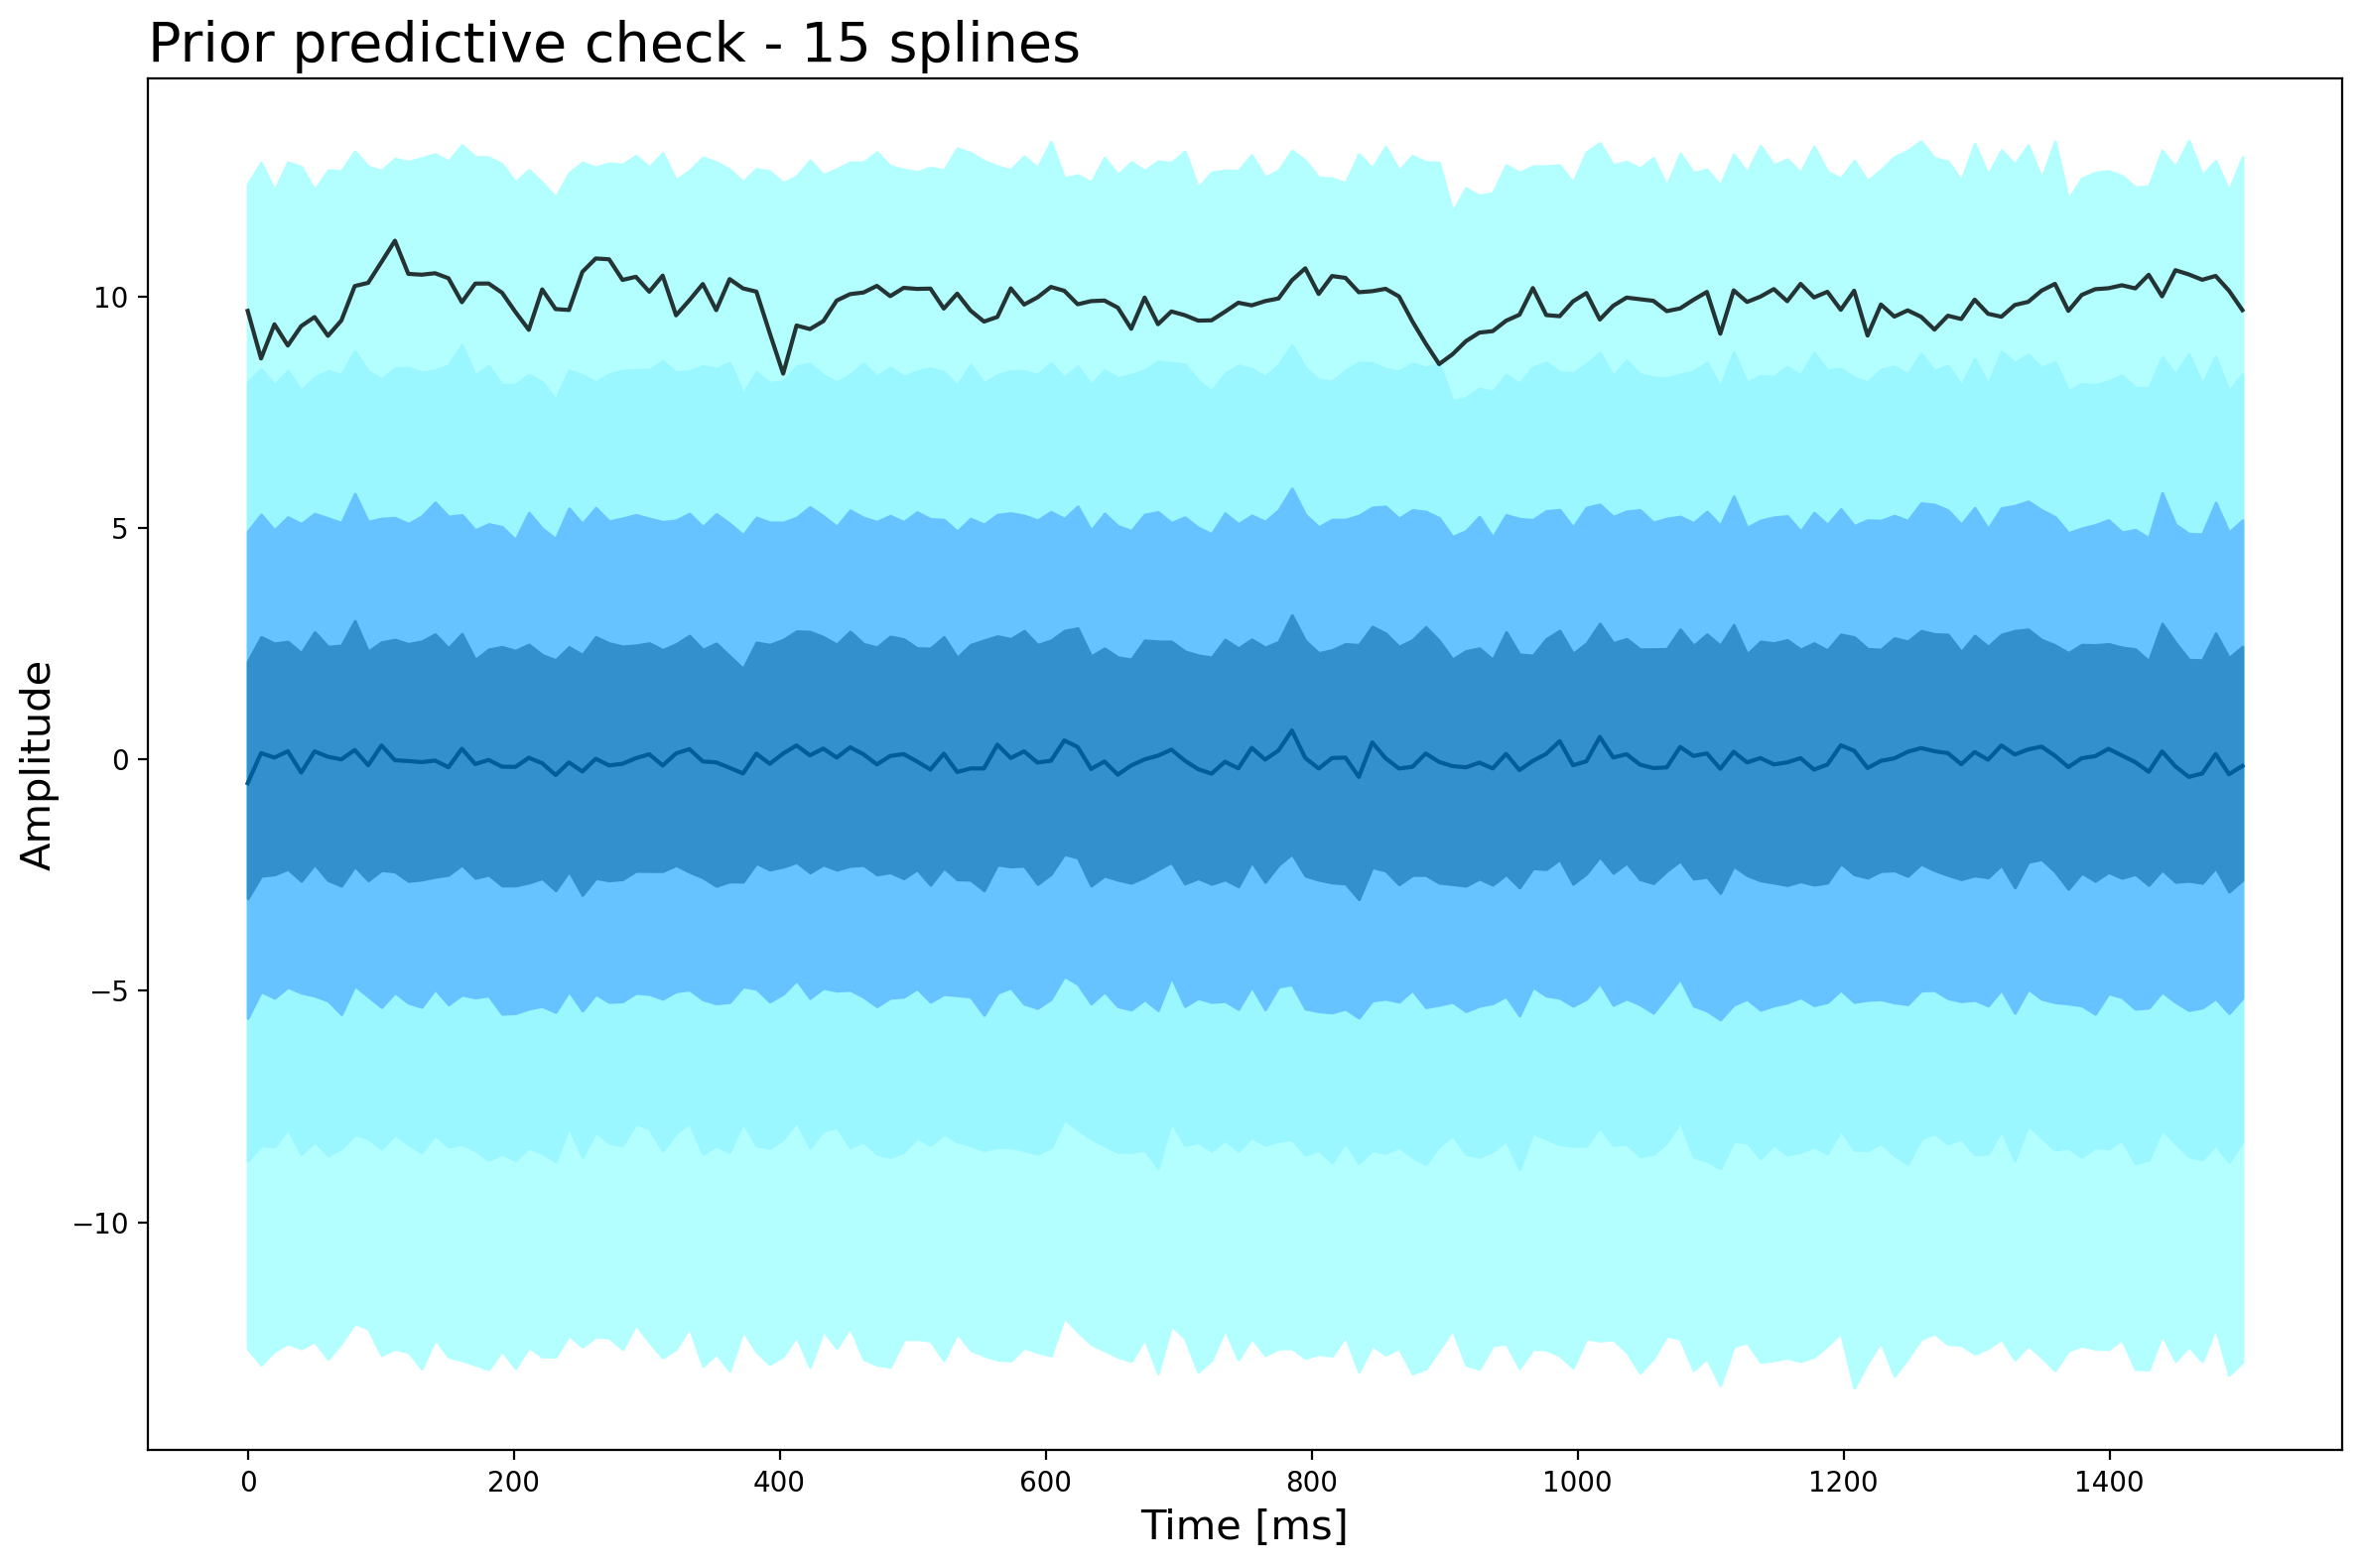

In [6]:
x = np.linspace(0,1500,N)
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
beta_pred= ppc_samples.stan_variable('betas')[:,:]
pred = ppc_samples.stan_variable('y_pred')
axes = ribbon_plot(x,pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Prior predictive check - 15 splines', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[1], color = 'k',alpha=0.8)

---
### Posterior analysis (model 1) [0-4 pts]: KAcper
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt] 
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- are the samples from posterior predictive distribution analyzed [1 pt] 

---
### Posterior analysis (model 2) [0-4 pts]:
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)

---
### Model comparison [0-4 pts]: Bartosz, Kacper
- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Was the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]
